In [2]:
# load data from DIRIF
from deeppipe.datasets.augmentations import ApplyAlbumination
from deeppipe.datasets.datasets import ImageMaskDataset
from deeppipe.datasets.preprocess import image_mask_resize, json2mask, convertImage2float, convertImageRgb2Hsv, normCeneterImage, convertMask2long, transposeImage, compose
from deeppipe.datasets.io import load_image, load_json
import albumentations as A
from deeppipe.models.unet import UnetHSVTrainer, UnetTrainer, UnetGRYTrainer
from deeppipe.models.denseaspp import DenseASPPGRYTrainer
from datetime import datetime
import pandas as pd
import os

batch_path = "/raid-dgx1/allanza/Segmentation/semantic_segmentation/data/DIRIF/batch_16_dirif_20191021"
image_batch_path = os.path.join(batch_path, "images")
labels_batch_path = os.path.join(batch_path, "mask_labels")

resize_image_size = [400,400]
label_dict = {"Road":1, "Bau":2, "Sw":3, "Parking": 4}
image_prefix = ""
mask_prefix = ""
image_suffix=".png"
mask_suffix=".json"
image_mask_preproc_fun = compose([ json2mask(label_dict), image_mask_resize(resize_image_size), convertMask2long,
                                   convertImage2float, normCeneterImage(0,255),transposeImage])
image_load_fun = load_image
mask_load_fun = load_json

dataset = ImageMaskDataset(image_batch_path, labels_batch_path, image_load_fun, mask_load_fun,
                                        image_mask_preproc_fun=image_mask_preproc_fun, image_mask_transform=None,
                                        image_prefix=image_prefix, mask_prefix=mask_prefix, image_suffix=image_suffix, mask_suffix=mask_suffix)


load in buffer: 38it [00:00, 71.61it/s]
preprocessing: 100%|██████████| 38/38 [00:00<00:00, 246.46it/s]


In [95]:
os.listdir("/raid-dgx1/allanza/Segmentation/semantic_segmentation/data/DIRIF/batch_18_dirif_AlarmesOctobre/images")

['E73.792X_7_avg_frame.png',
 'E73.792X_1_avg_frame.png',
 'E73.794A_3_avg_frame.png',
 'E73.789U_2_avg_frame.png',
 'E73.788T_5_avg_frame.png',
 'E73.788T_9_avg_frame.png',
 'E73.792X_4_avg_frame.png',
 'E73.795C_8_avg_frame.png',
 'E73.788T_10_avg_frame.png',
 'E73.788T_0_avg_frame.png',
 'E73.792X_6_avg_frame.png']

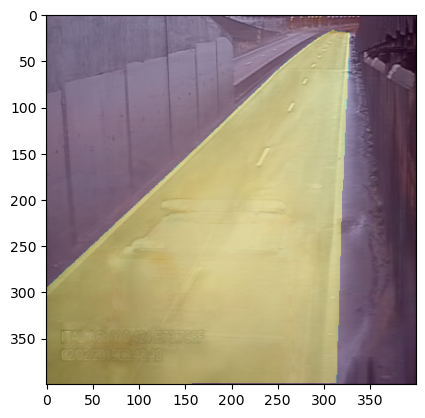

In [89]:
import matplotlib.pyplot as plt
import numpy as np
x,y = dataset[34]
y = y==1
img = np.transpose(x, [1,2,0])
plt.imshow(img)
plt.imshow(y, alpha=0.3)

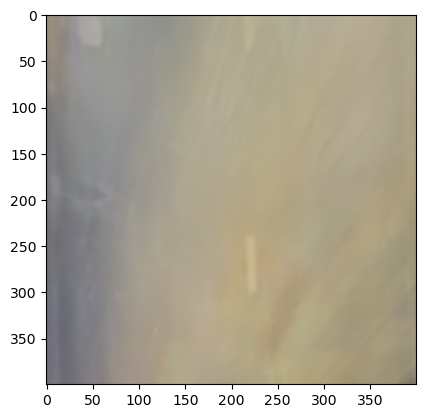

In [81]:
# Visualize certain differences
from skimage import transform
from scipy.spatial import distance_matrix
from skimage import transform
import numpy as np
import cv2

def get_left_right_lane_points_from_segmentation(street_segmentation, eps_border_lane_point=5, min_pix_street_width=25, max_pix_street_width=100):
    # find left and right lane coordinates
    street_mask = (street_segmentation != 0).astype(np.uint8)
    rows, cols = street_mask.shape[:2]
    left_lane, right_lane = [], []
    for y in range(eps_border_lane_point, min(rows-eps_border_lane_point, rows)):
        xx = np.where(street_mask[y] == 1)[0]
        if min_pix_street_width < len(xx) < max_pix_street_width: 
            if abs(xx[0] - 0) > eps_border_lane_point: left_lane += [ [y,xx[0]] ]
            if abs(xx[-1] - cols) > eps_border_lane_point: right_lane += [ [y,xx[-1]] ]
    left_lane = np.array(left_lane)#[::2] # use half the points is enough
    right_lane = np.array(right_lane)#[::2]
    return left_lane, right_lane

def get_left_right_lane_matching_pairs(left_lane, right_lane):
    # closest match pairs (greedy)
    dm = np.linalg.norm(left_lane[:, None, :] - right_lane[None, :, :], axis=-1)
    matches = []
    for k in range(min(len(right_lane), len(left_lane))):
        match = np.unravel_index(dm.argmin(), dm.shape)
        matches += [match]
        # updata match by making them unreacheable
        dm[match[0],:] = 1e10
        dm[:,match[1]] = 1e10

    matches = np.array(matches)
    matching_point_pairs = np.array(list(zip(left_lane[matches[:,0]], right_lane[matches[:,1]])))
    return matching_point_pairs

def filter_matching_pairs_by_slope(matching_point_pairs):

    ly,lx = matching_point_pairs[:,0,0], matching_point_pairs[:,0,1]
    ry,rx = matching_point_pairs[:,1,0], matching_point_pairs[:,1,1]
    match_slopes = (ly - ry)/(lx - rx + 1e-10)
    mean_slope = np.mean(match_slopes)
    std_slope = np.std(match_slopes)
    lower, upper = mean_slope - (3*std_slope+1e-10), mean_slope + (3*std_slope+1e-10)
    avg_filter = np.argwhere( np.logical_and( match_slopes>lower, match_slopes<upper ) )[...,0]
    matching_point_pairs = matching_point_pairs[ avg_filter ]
    return matching_point_pairs


def get_homograpy_from_street_segmentation(street_segmentation, dst_shape=None, eps_border_lane_point=5, 
                                           min_pix_street_width=150, max_pix_street_width=600,
                                           dx=200, dy=200):

    left_lane, right_lane = get_left_right_lane_points_from_segmentation(street_segmentation, eps_border_lane_point=eps_border_lane_point,
                                                                         max_pix_street_width=max_pix_street_width, 
                                                                         min_pix_street_width=min_pix_street_width)
    matching_point_pairs = get_left_right_lane_matching_pairs(left_lane, right_lane)
    matching_point_pairs = filter_matching_pairs_by_slope(matching_point_pairs)

    # NOTE: opencV perspective transform inverses x and y coordinates.
    # homography
    # bottom left, bottom right, top left, top right
    src_p0, src_p1, src_p2, src_p3 = matching_point_pairs[0,0][::-1], matching_point_pairs[0,1][::-1], matching_point_pairs[-1,0][::-1], matching_point_pairs[-1,1][::-1]
    src_points = np.array([ src_p0, src_p1, src_p2, src_p3 ]).astype(np.float32)
    if dst_shape is not None:
        src_points *= np.array(dst_shape[::-1], dtype=np.float32) / np.array(street_segmentation.shape[:2][::-1], dtype=np.float32)

    dst_points = ( np.array([ [0,0], [dx,0], [0,dy], [dx,dy] ])).astype(np.float32)
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    invM = np.linalg.inv(M)

    return M, invM, matching_point_pairs

M, invM, matching_point_pairs = get_homograpy_from_street_segmentation(y,eps_border_lane_point=1, dx=400, dy=400)

imgT = cv2.warpPerspective(img, M, (400,400))
plt.imshow(imgT)

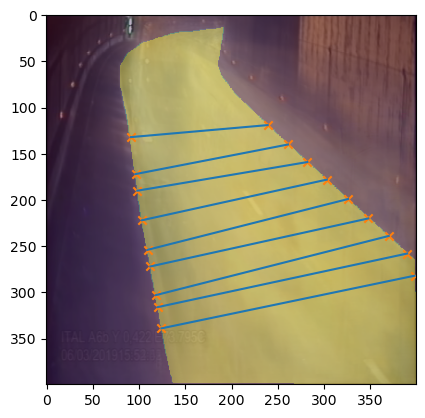

In [82]:
plt.imshow(img)
skip_n = 20
for p1,p2 in zip(matching_point_pairs[::skip_n,:,0], matching_point_pairs[::skip_n,:,1]):
    plt.plot(p2,p1, c='tab:blue')
plt.scatter(matching_point_pairs[::skip_n,0,1], matching_point_pairs[::skip_n,0,0], marker='x', c='tab:orange')
plt.scatter(matching_point_pairs[::skip_n,1,1], matching_point_pairs[::skip_n,1,0], marker='x', c='tab:orange')
plt.imshow(y, alpha=0.3)